In [278]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.utils import resample
from lifelines import KaplanMeierFitter, statistics

In [279]:
DATA_DIR = Path("datasets/luad_tcga_gdc")
OUT_DIR = Path("./processed"); OUT_DIR.mkdir(exist_ok=True)

TPM_FILE = DATA_DIR / "data_mrna_seq_tpm.txt"
CNA_FILE = DATA_DIR / "data_cna.txt"
MUT_FILE = DATA_DIR / "data_mutations.txt"
SAMP_FILE = DATA_DIR / "data_clinical_sample.txt"
PAT_FILE = DATA_DIR / "data_clinical_patient.txt"

TOP_EXPR_GENES = 32636 # 80%
MIN_CNA_FREQ   = 0.05
MIN_MUT_FREQ   = 0.05

In [280]:
def load_table(path, **kw):
    return pd.read_csv(path, sep="\t", comment="#", low_memory=False, **kw)

def mad(arr):
    med = np.median(arr)
    return np.median(np.abs(arr-med))

def tcga_sample(s):
    return isinstance(s,str) and re.fullmatch(r"TCGA-[A-Z0-9]{2}-[A-Z0-9]{4}-01A",s)


In [281]:
expr = load_table(TPM_FILE).set_index("Entrez_Gene_Id")
cna = load_table(CNA_FILE).set_index("Entrez_Gene_Id")
mut = load_table(MUT_FILE)
samp = load_table(SAMP_FILE)

In [282]:
common_ids = sorted({c for c in expr.columns 
                     if tcga_sample(c)} &
                    {c for c in cna.columns 
                     if tcga_sample(c)} &
                    {s for s in samp["SAMPLE_ID"] 
                     if tcga_sample(s)})
expr, cna = expr[common_ids], cna[common_ids]

In [283]:
expr_log2 = np.log2(expr+1)
expr_sel  = expr_log2.loc[expr_log2.apply(mad, axis=1).nlargest(TOP_EXPR_GENES).index]
print(len(expr_sel))
expr_sel.index = expr_sel.index.astype(str)+"_expr"

32636


In [284]:
cna_sel = cna.loc[(cna!=0).mean(axis=1)>=MIN_CNA_FREQ]
cna_sel.index = cna_sel.index.astype(str)+"_cna"

In [285]:
mut = mut[mut["Variant_Classification"] != "Silent"].copy()
if "FILTER" in mut.columns:
    mut = mut[mut["FILTER"].isin({"PASS", ".", "", np.nan})]
mut = mut[mut["Tumor_Sample_Barcode"].isin(common_ids)]
mut["val"]=1
mut_bin = mut.pivot_table(index="Entrez_Gene_Id", columns="Tumor_Sample_Barcode", values="val", aggfunc="max", fill_value=0)
mut_sel = mut_bin.loc[mut_bin.mean(axis=1)>=MIN_MUT_FREQ]
mut_sel.index = mut_sel.index.astype(str)+"_mut"

In [286]:
X = pd.concat([expr_sel, cna_sel, mut_sel]).T
X = X.loc[:, X.var()>0]
X_z = ((X - X.mean())/X.std()).fillna(0)

In [287]:
PCA_VAR_TARGET = 0.80

pca_full = PCA(svd_solver="randomized", random_state=0).fit(X_z)
optimal_n = np.searchsorted(np.cumsum(pca_full.explained_variance_ratio_), PCA_VAR_TARGET)+1
pca = PCA(n_components=optimal_n, svd_solver="randomized", random_state=0)
pcs = pca.fit_transform(X_z)
print(f'⇒  {optimal_n} компонентов дают ≥ {PCA_VAR_TARGET:.0%} дисперсии')

⇒  119 компонентов дают ≥ 80% дисперсии


In [288]:
pca_df = pd.DataFrame(pcs, index=X_z.index, columns=[f"PC{i+1}" for i in range(optimal_n)])

pca_df_plt = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(optimal_n)],
    "explained": pca.explained_variance_ratio_,
    "cumulative": np.cumsum(pca.explained_variance_ratio_),
})

pca_df.to_csv(OUT_DIR/"luad_pca_variance.csv", index=False)

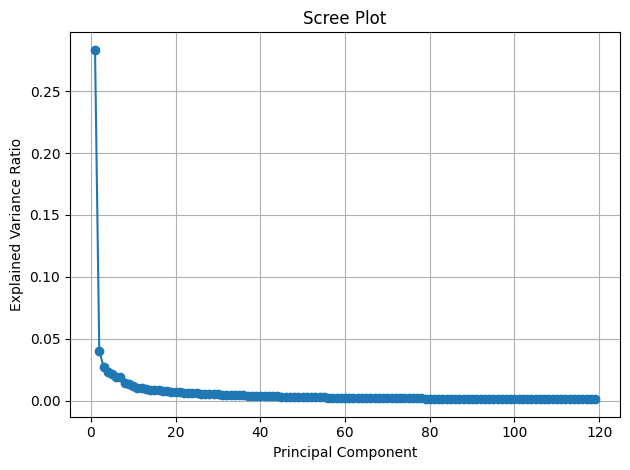

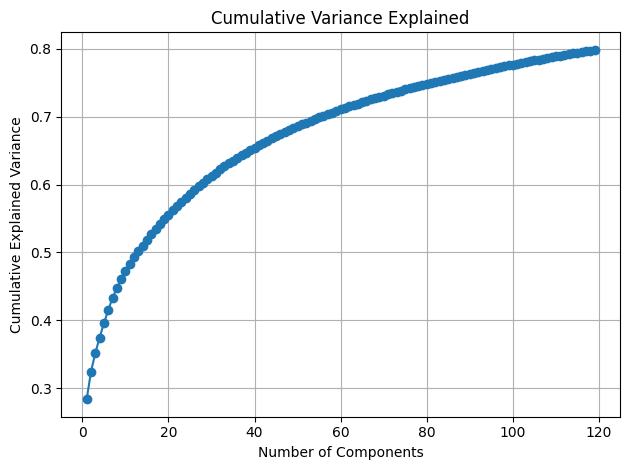

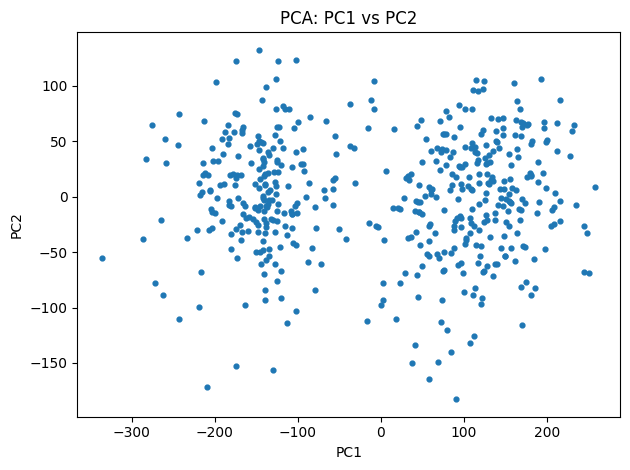

In [289]:
plt.figure()
plt.plot(pca_df_plt["PC"].str.replace("PC", "").astype(int), pca_df_plt["explained"], marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.grid(True)
plt.tight_layout()
plt.savefig(OUT_DIR / "pca_scree.png")

plt.figure()
plt.plot(pca_df_plt["PC"].str.replace("PC", "").astype(int), pca_df_plt["cumulative"], marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Variance Explained")
plt.grid(True)
plt.tight_layout()
plt.savefig(OUT_DIR / "pca_cumulative.png")


if pca_df.shape[1] >= 2:
    plt.figure()
    plt.scatter(pca_df["PC1"], pca_df["PC2"], s=12)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA: PC1 vs PC2")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "pca_pc1_pc2.png")

In [290]:
TEST_SIZE = 0.20

train_idx, test_idx = train_test_split(pca_df.index, test_size=TEST_SIZE, random_state=0)
X_train, X_test = pca_df.loc[train_idx], pca_df.loc[test_idx]

In [291]:
def eval_and_store(name, k, labels):
    sil = silhouette_score(X_train, labels)
    results[(name,k)] = (labels, sil)

def fit_predict(method, k, data):
    if method=="kmeans":
        return KMeans(n_clusters=k, n_init='auto', random_state=0).fit_predict(data)
    if method=="ward":
        return AgglomerativeClustering(n_clusters=k, linkage="ward").fit_predict(data)
    if method=="gmm":
        return GaussianMixture(n_components=k, covariance_type="full", random_state=0).fit_predict(data)

In [292]:
results = {}

for method in ["kmeans","ward","gmm"]:
    for k in range(2, 10):
        lbl = fit_predict(method,k,X_train)
        eval_and_store(method,k,lbl)


best_key,(train_labels_arr,best_sil)=max(results.items(), key=lambda x:x[1][1])
train_labels = pd.Series(train_labels_arr, index=train_idx, name="cluster")
method_best, k_best = best_key
print(f"Best (train) = {best_key}, silhouette={best_sil:.3f}")

Best (train) = ('kmeans', 2), silhouette=0.275


In [293]:
if method_best=="kmeans":
    best_model = KMeans(n_clusters=k_best, n_init='auto', random_state=0).fit(X_train)
    test_labels = best_model.predict(X_test)
elif method_best=="gmm":
    best_model = GaussianMixture(n_components=k_best,covariance_type='full',random_state=0).fit(X_train)
    test_labels = best_model.predict(X_test)
elif method_best=="ward":
    best_model = AgglomerativeClustering(n_clusters=k_best, linkage='ward')
    test_labels = best_model.fit_predict(X_test)

sil_test = silhouette_score(X_test, test_labels)
print(f"Test silhouette = {sil_test:.3f}")

Test silhouette = 0.249


In [294]:
labels_full = pd.Series(index=pca_df.index, dtype=int, name="cluster")
labels_full.loc[train_idx] = train_labels.values

labels_full.loc[test_idx] = test_labels

labels_full.to_csv(OUT_DIR/"luad_clusters.csv", header=True)

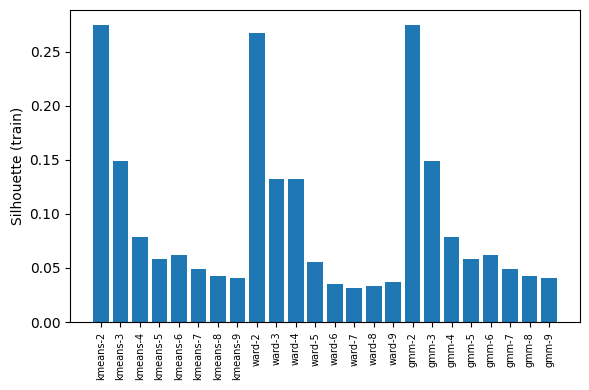

In [295]:
plt.figure(figsize=(6,4))
plt.bar([f"{k[0]}-{k[1] if k[1] else ''}" for k in results], [v[1] for v in results.values()])
plt.xticks(rotation=90, fontsize=7)
plt.ylabel("Silhouette (train)")
plt.tight_layout()
plt.savefig(OUT_DIR/"silhouette_methods.png", dpi=300)

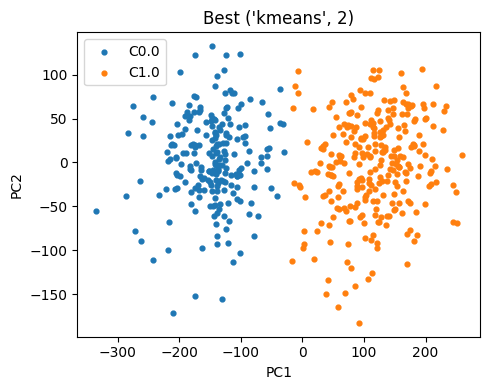

In [296]:
plt.figure(figsize=(5,4))
for cl in sorted(set(labels_full)):
    mask = labels_full == cl
    plt.scatter(pca_df.loc[mask,"PC1"], pca_df.loc[mask,"PC2"], s=12, label=f"C{cl}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.title(f"Best {best_key}")
plt.tight_layout()
plt.savefig(OUT_DIR/"pca_best_clusters.png")

In [297]:
BOOT_ROUNDS    = 100

ari_vals=[]
for i in range(BOOT_ROUNDS):
    boot_idx = resample(train_idx, replace=True, random_state=i)
    X_b = X_train.loc[boot_idx]
    if method_best=="kmeans":
        lb = KMeans(n_clusters=k_best, n_init='auto', random_state=0).fit_predict(X_b)
    elif method_best=="gmm":
        lb = GaussianMixture(n_components=k_best,covariance_type='full',random_state=0).fit_predict(X_b)
    elif method_best=="ward":
        lb = AgglomerativeClustering(n_clusters=k_best, linkage='ward').fit_predict(X_b)
    else:
        continue
    ari_vals.append(adjusted_rand_score(train_labels.loc[boot_idx], lb))

/var/folders/4m/bmr6pj2s4k996yk6vfh6_1y40000gn/T/ipykernel_42614/1387897028.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(ari_vals, vert=False, labels=["ARI"])


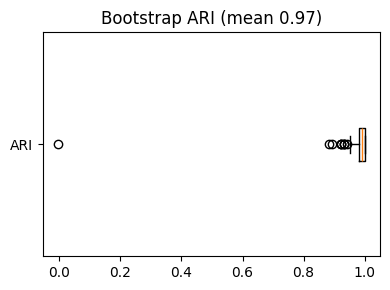

In [298]:
pd.Series(ari_vals, name="ARI").to_csv(OUT_DIR/"cluster_stability_bootstrap.csv", index=False)
plt.figure(figsize=(4,3))
plt.boxplot(ari_vals, vert=False, labels=["ARI"])
plt.title(f"Bootstrap ARI (mean {np.mean(ari_vals):.2f})")
plt.tight_layout(); plt.savefig(OUT_DIR/"bootstrap_ari.png", dpi=300)

pca_df.to_csv(OUT_DIR/"luad_pca_scores.csv")

In [299]:
url = "https://ftp.ncbi.nlm.nih.gov/gene/DATA/GENE_INFO/Mammalia/Homo_sapiens.gene_info.gz"
gene_map = (
    pd.read_csv(
        url,
        sep="	",
        compression="gzip",
        comment="#",
        header=None,
        usecols=[1, 2],
        names=["GeneID", "Symbol"],
    )
    .set_index("GeneID")["Symbol"]
)

for c in sorted(labels_full.unique()):
    mask = labels_full == c
    freq = mut_bin.loc[:, mask].mean(axis=1)
    df_freq = (
        pd.DataFrame({
            "Entrez_Gene_Id": freq.index,
            "HUGO_Symbol": freq.index.map(lambda x: gene_map.get(x, "?")),
            "Frequency": freq.values,
        })
        .sort_values("Frequency", ascending=False)
    )

    top_df = df_freq.head(10)
    top_df.index = top_df.apply(lambda r: f"{r['HUGO_Symbol']} ({int(r['Entrez_Gene_Id'])})", axis=1)
    print(f"Cluster {c} top genes:")
    print(top_df["Frequency"], end="\n\n")

Cluster 0.0 top genes:
TP53 (7157)       0.371429
TTN (7273)        0.314286
MUC16 (94025)     0.304762
CSMD3 (114788)    0.276190
RYR2 (6262)       0.266667
KRAS (3845)       0.257143
LRP1B (53353)     0.247619
ZFHX4 (79776)     0.209524
XIRP2 (129446)    0.200000
USH2A (7399)      0.185714
Name: Frequency, dtype: float64

Cluster 1.0 top genes:
TP53 (7157)       0.590747
TTN (7273)        0.580071
CSMD3 (114788)    0.469751
MUC16 (94025)     0.462633
RYR2 (6262)       0.405694
USH2A (7399)      0.387900
ZFHX4 (79776)     0.373665
LRP1B (53353)     0.370107
XIRP2 (129446)    0.298932
KRAS (3845)       0.295374
Name: Frequency, dtype: float64



In [300]:
clusters = pd.Series(labels_full.values, index=pca_df.index, name="cluster")
samp = load_table(SAMP_FILE).set_index("SAMPLE_ID")
pat  = load_table(PAT_FILE).set_index("PATIENT_ID")


samp["cluster"] = clusters
samp = samp.dropna(subset=["cluster"])
samp["cluster"] = samp["cluster"].astype(int)

pat["cluster"] = (
    samp.groupby("PATIENT_ID")["cluster"]
        .first()
)

pat = pat.dropna(subset=["cluster"])
pat["cluster"] = pat["cluster"].astype(int)


time  = pat["OS_MONTHS"]
event = pat["OS_STATUS"].str.startswith("1").astype(int)


valid = time.notna() & (time > 0)
pat = pat[valid]
time = time[valid]
event = event[valid]

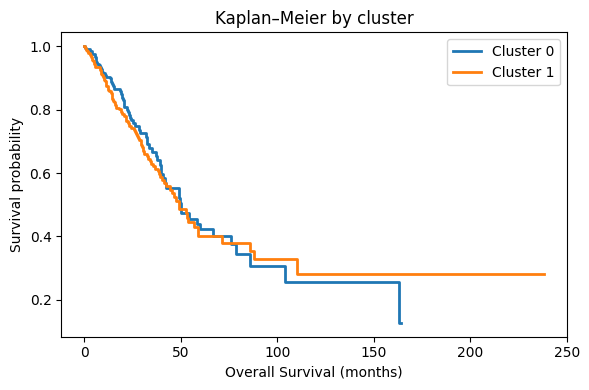

In [301]:
plt.figure(figsize=(6, 4))
ax = plt.gca()
km = KaplanMeierFitter()
summary_rows = []

for c in sorted(pat["cluster"].unique()):
    m = pat["cluster"] == c
    km.fit(time[m], event[m], label=f"Cluster {c}")
    km.plot(ax=ax, ci_show=False, linewidth=2)
    summary_rows.append({
        "cluster": int(c),
        "n": int(m.sum()),
        "median_OS_months": km.median_survival_time_
    })

ax.set_xlabel("Overall Survival (months)")
ax.set_ylabel("Survival probability")
ax.set_title("Kaplan–Meier by cluster")
plt.tight_layout()
plt.savefig(OUT_DIR / "km_clusters.png", dpi=300)

In [302]:
clusters_present = sorted(pat["cluster"].unique())

c0, c1 = clusters_present
res = statistics.logrank_test(
    time[pat.cluster == c0],
    time[pat.cluster == c1],
    event_observed_A=event[pat.cluster == c0],
    event_observed_B=event[pat.cluster == c1],
)
p_val = res.p_value
print(f"Log-rank p-value (Cluster {c0} vs {c1}) = {p_val:.4f}")


pd.DataFrame(summary_rows).assign(logrank_p=p_val).to_csv(OUT_DIR / "cluster_survival_summary.csv", index=False)

Log-rank p-value (Cluster 0 vs 1) = 0.6105
